# 导包

In [110]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.io as sio

base = "/content/drive/MyDrive/Colab Notebooks/Statistical-Learning-Method-Python/CH02-Perceptron"

# 导入数据

In [111]:
data_path = base + "/CH02-data.mat"
data = sio.loadmat(data_path)

X = data['X']
y = data['y'].astype(int)

# 将标签转为1和-1
for i in range(y.shape[0]):
  y[i] = -1 if y[i] == 0 else 1

# 数据可视化

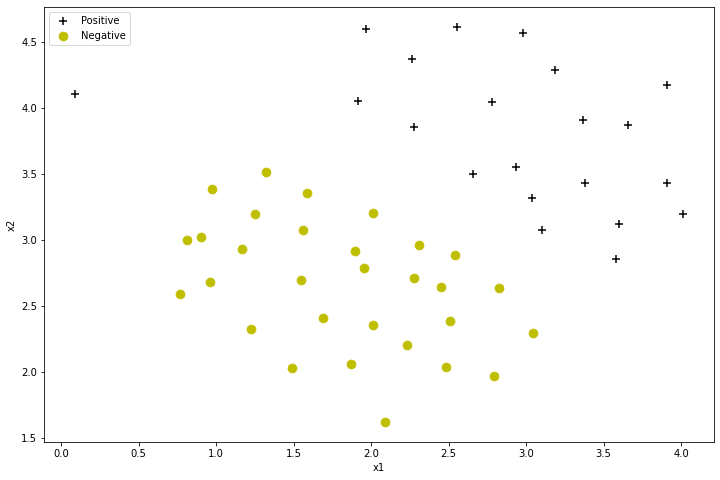

In [112]:
df = pd.DataFrame({'x1': X[:, 0], 'x2':X[:, 1], 'y':np.ravel(y)})

positive = df[df['y'].isin([1])]
negative = df[df['y'].isin([-1])]

fig, ax = plt.subplots(figsize=(12, 8))
ax.scatter(positive['x1'], positive['x2'], color="black", s=75, marker='+', label="Positive")
ax.scatter(negative['x1'], negative['x2'], color="y", s=75, marker='o', label="Negative")
ax.legend(loc=2)
ax.set_xlabel("x1")
ax.set_ylabel("x2")
plt.show()

# 感知机模型
$$
f(x)=sign(w\cdot x+b)
$$
其中：$w\in \mathbb{R}^n,b\in \mathbb{R}$，
$
sign(x)=\left\{\begin{matrix}
+1,\ \ x\ge 0 \\
-1,\ \ x<0
\end{matrix}\right.
$

In [113]:
def sign(x):
  return 1 if x >= 0 else -1

In [114]:
def LinearRegression(x, w, b):
  ret = w.T @ x + b
  return ret

In [115]:
def Hypothesis(x, w, b):
  return sign(LinearRegression(x, w, b))

# 感知机学习策略


## 误分类点到超平面S的总距离
$$
L(w,b)=-\sum_{x_i\in M}y_i(w\cdot x_i + b)
$$
其中：M为误分类点的集合，$x_i\in \mathcal{X} =\mathbb{R}^n$，$w\in \mathbb{R}^n,b\in \mathbb{R}$


In [116]:
def ComputeCost(X, w, b):
  cost = 0
  for i in range(X.shape[0]):
    y_hat = LinearRegression(X[i].reshape(X.shape[1], 1), w, b)
    if y[i] * y_hat <= 0:
      cost += y[i] * y_hat

  return -1 * cost

In [117]:
w = np.ones(2)
b = 0
ComputeCost(X, w, b)

array([134.38635])

# 感知机学习算法

## 原始形式
输入：训练数据集$T=\{(x_1,y_1),(x_2,y_2),\dots, (x_N,y_N)\}$，其中$x_i\in \mathcal{X}=\mathbb{R}^n$，$y_i\in \mathcal{Y}=\{-1,+1\}$，$i=1,2,\dots ,N$；学习率$\eta(0\le \eta \le 1)$

输出：w,b；感知机模型$f(x)=sign(w\cdot x+b)$

（1）选择初值$w_0,b_0$

（2）在训练集中选取数据$(x_i,y_i)$

（3）如果$y_i(w\cdot x_i+b)\le0$，
$$
w\leftarrow w+\eta y_ix_i \\
b\leftarrow b+\eta y_i
$$

（4）转至（2），直至训练集中没有误分类点。



### 计算原始形式问题

In [118]:
def StochasticGradientDescent(X, LearningRate):
  # 初始化参数（1）
  w = np.ones(2)
  b = 0

  while 1:
    # 选择误分类点（2）
    index = -1
    for i in range(X.shape[0]):
      y_hat = LinearRegression(X[i].reshape(X.shape[1], 1), w, b)
      if y[i] * y_hat <= 0:
        index = i
    if index == -1: # 没有误分类点（4）
      break
    # 梯度下降（3）
    w = w + LearningRate * y[index] * X[index]
    b = b + LearningRate * y[index]

  return w, b

### 可视化线性超平面

[ 8.98983 26.1088 ] [-104]


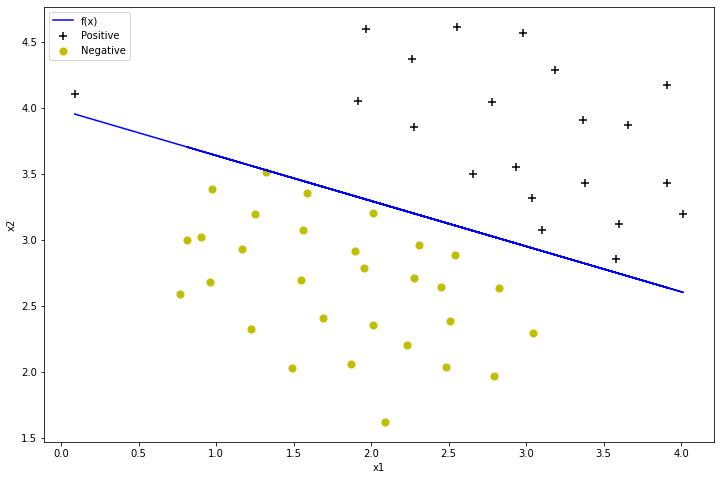

In [123]:
w, b = StochasticGradientDescent(X, LearningRate=1)
print(w, b)

x1 = X[:, 0]
x2 = (w[0] * x1 + b) / (-1 * w[1])

fig, ax = plt.subplots(figsize=(12, 8))
ax.scatter(positive['x1'], positive['x2'], color="black", s=50, marker='+', label="Positive")
ax.scatter(negative['x1'], negative['x2'], color="y", s=50, marker='o', label="Negative")
ax.plot(x1, x2, color="blue", label="f(x)")
ax.legend(loc=2)
ax.set_xlabel("x1")
ax.set_ylabel("x2")
plt.show()

## 对偶形式
输入：训练数据集$T=\{(x_1,y_1),(x_2,y_2),\dots, (x_N,y_N)\}$，其中$x_i\in \mathcal{X}=\mathbb{R}^n$，$y_i\in \mathcal{Y}=\{-1,+1\}$，$i=1,2,\dots ,N$；学习率$\eta(0\le \eta \le 1)$

输出：$\alpha ,b$；感知机模型$f(x)=sign(\sum_{j=1}^N\alpha_jy_jx_j\cdot x+b)$，其中$\alpha =(\alpha_1, \alpha_2, \dots, \alpha_N)^T$，$\alpha_i=n_i\eta$，$n_i$是点$(x_i,y_i)$被误分类的次数。

（1）$\alpha \leftarrow 0,b \leftarrow 0$

（2）在训练集中选取数据$(x_i,y_i)$

（3）如果$y_i(\sum_{j=1}^N\alpha_jy_jx_j\cdot x_i+b)\le0$，
$$
\alpha_i\leftarrow \alpha_i + \eta \\
b\leftarrow b+\eta y_i
$$

（4）转至（2），直至训练集中没有误分类点。



### Gram矩阵
$$
\mathbb{G}=[x_i\cdot x_j]_{N\times N}
$$

In [121]:
def GramMatrix(X):
  G = np.zeros([X.shape[0], X.shape[0]])
  for i in range(X.shape[0]):
    for j in range(X.shape[0]):
      G[i, j] = np.sum(X[i] * X[j])
  return G

### 计算对偶问题

In [124]:
def ComputeDualProblem(X, LearningRate):
  # 初始化（1）
  alpha = np.zeros(X.shape[0])
  b = 0
  G = GramMatrix(X)

  while 1:
    # 选择误分类点（2）
    index = -1
    for i in range(X.shape[0]):
      tmp = 0
      for j in range(X.shape[0]):
        if alpha[j] == 0: continue # 快速处理
        tmp += alpha[j] * y[j] * G[j, i]
      tmp += b
      
      if y[i] * tmp <= 0: # 如果...<=0（3）
        index = i
        break # 找到一个就可以停了
    if index == -1: # 没有误分类点（4）
      break
    # 下降（3）
    alpha[index] += LearningRate
    b = b + LearningRate * y[index]
  return alpha, b

In [125]:
alpha, b = ComputeDualProblem(X, LearningRate=0.5)

### 可视化线性超平面

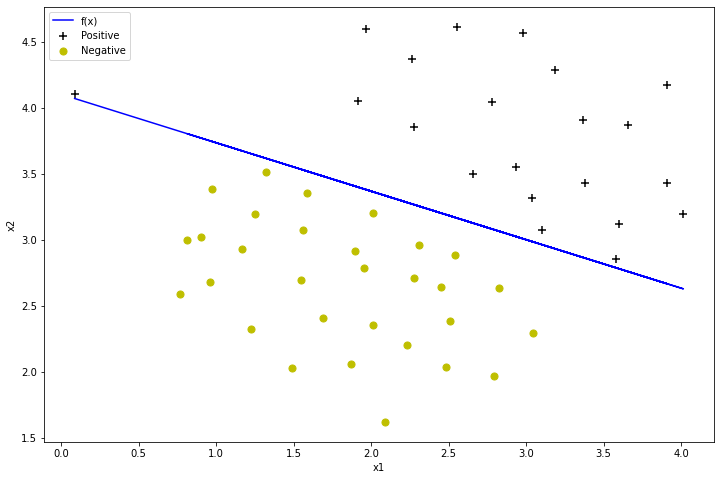

In [126]:
w = np.zeros([X.shape[1], 1])
for i in range(X.shape[0]):
  w += (alpha[i] * y[i] * X[i]).reshape([2,1])

x1 = X[:, 0]
x2 = (w[0] * x1 + b) / (-1 * w[1])

fig, ax = plt.subplots(figsize=(12, 8))
ax.scatter(positive['x1'], positive['x2'], color="black", s=50, marker='+', label="Positive")
ax.scatter(negative['x1'], negative['x2'], color="y", s=50, marker='o', label="Negative")
ax.plot(x1, x2, color="blue", label="f(x)")
ax.legend(loc=2)
ax.set_xlabel("x1")
ax.set_ylabel("x2")
plt.show()